In [ ]:
# pip install keras-tuner

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras_tuner as kt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

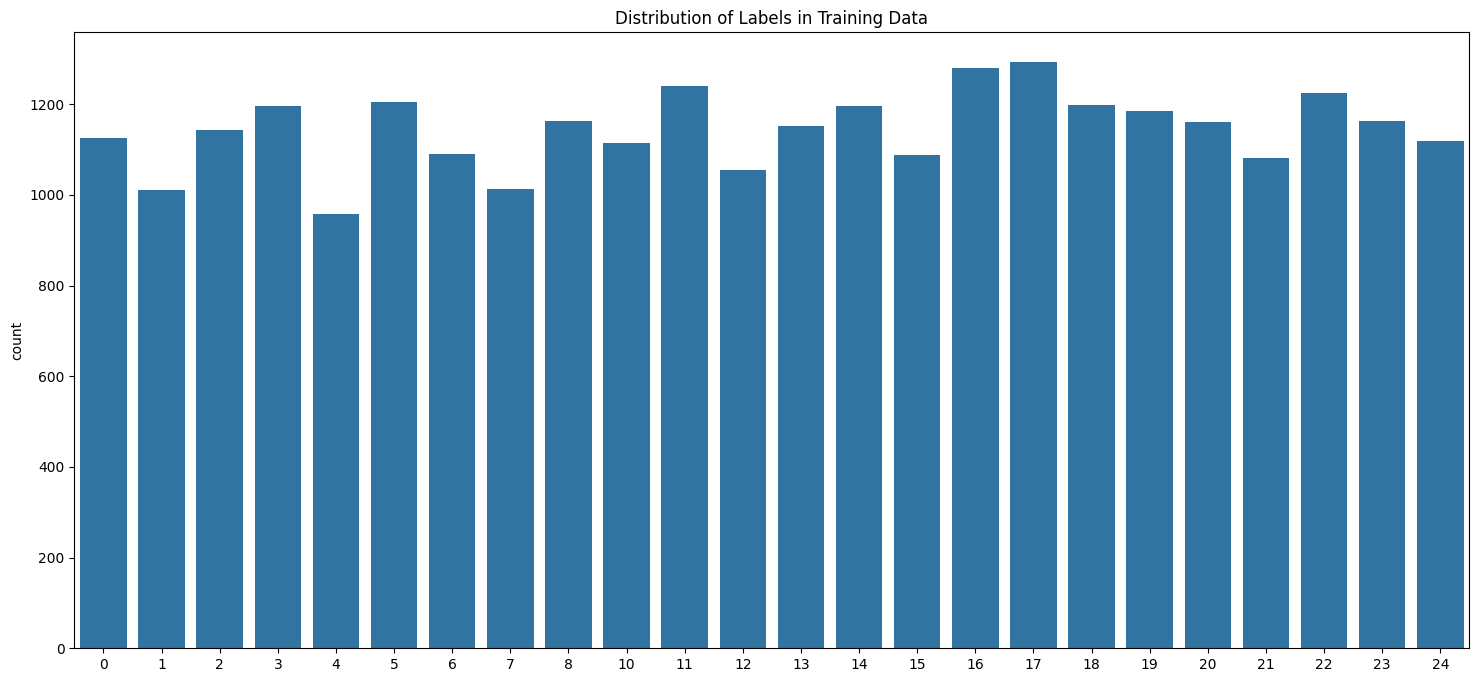

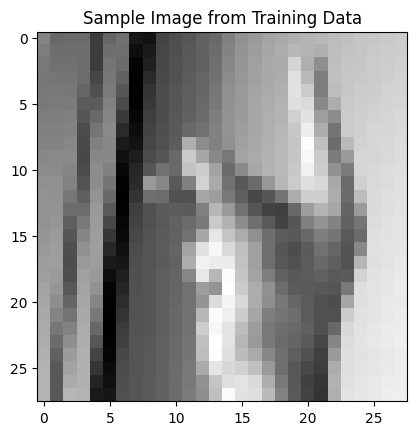

Test images shape: (7172, 28, 28, 1)


In [ ]:
# Load training and test datasets
train = pd.read_csv('/content/drive/MyDrive/Software Engineering Project/kaggle-mnist/sign_mnist_train/sign_mnist_train.csv')
test  = pd.read_csv('/content/drive/MyDrive/Software Engineering Project/kaggle-mnist/sign_mnist_test/sign_mnist_test.csv')

# Extract training labels and plot the distribution
labels = train['label'].values
plt.figure(figsize=(18, 8))
sns.countplot(x=labels)
plt.title("Distribution of Labels in Training Data")
plt.show()

# Drop labels and prepare image data (flattening 28x28 images)
train.drop('label', axis=1, inplace=True)
images = train.values
images = np.array([np.reshape(i, (28, 28)) for i in images])
images = np.array([i.flatten() for i in images])

# One-hot encode the training labels
label_binrizer = LabelBinarizer()
labels_encoded = label_binrizer.fit_transform(labels)

# Split into training and validation sets (90% training, 10% validation)
x_train, x_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.1, random_state=101)

# Scale pixel values to [0, 1]
x_train = x_train / 255.0
x_test  = x_test / 255.0

# Reshape images to match CNN input: (28, 28, 1)
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test  = x_test.reshape(x_test.shape[0], 28, 28, 1)

# Display the first image to verify
plt.imshow(x_train[0].reshape(28, 28), cmap='gray')
plt.title("Sample Image from Training Data")
plt.show()

# Prepare the test dataset similarly
test_labels = test['label'].values
test.drop('label', axis=1, inplace=True)
test_images = test.values
test_images = np.array([np.reshape(i, (28, 28)) for i in test_images])
test_images = np.array([i.flatten() for i in test_images])
test_labels_encoded = label_binrizer.fit_transform(test_labels)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

print("Test images shape:", test_images.shape)

In [ ]:
num_classes = 24  # For sign language (24 letters)
def build_model(hp):
    model = Sequential()

    # First Convolutional Layer
    model.add(Conv2D(
        filters=hp.Int('conv1_filters', min_value=32, max_value=256, step=32),
        kernel_size=(3, 3),
        activation='relu',
        input_shape=(28, 28, 1)
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second Convolutional Layer
    model.add(Conv2D(
        filters=hp.Int('conv2_filters', min_value=64, max_value=512, step=64),
        kernel_size=(3, 3),
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third Convolutional Layer
    model.add(Conv2D(
        filters=hp.Int('conv3_filters', min_value=128, max_value=512, step=64),
        kernel_size=(3, 3),
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    # Fully Connected Layer
    model.add(Dense(
        units=hp.Int('dense_units', min_value=64, max_value=512, step=64),
        activation='relu'
    ))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0, max_value=0.6, step=0.05)))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    # Learning rate selection
    learning_rate = hp.Choice('learning_rate', values=[5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4])

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# Use Hyperband for a broad search with early stopping to quickly eliminate poor configurations.
tuner_hyperband = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_tuning_dir',
    project_name='hyperband_tuning'
)

# Run Hyperband search
tuner_hyperband.search(
    x_train,
    y_train,
    epochs=10,
    validation_data=(x_test, y_test)
)

# Retrieve the best hyperparameters found by Hyperband
best_hp_hyperband = tuner_hyperband.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperband Hyperparameters:")
print(best_hp_hyperband.values)

Trial 30 Complete [00h 01m 04s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 16m 49s
Best Hyperband Hyperparameters:
{'conv1_filters': 128, 'conv2_filters': 384, 'conv3_filters': 512, 'dense_units': 192, 'dropout_rate': 0.1, 'learning_rate': 0.0005, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0013'}


In [ ]:
# Best Hyperband Hyperparameters:
# {'conv1_filters': 128, 'conv2_filters': 384, 'conv3_filters': 512, 'dense_units': 192, 'dropout_rate': 0.1, 'learning_rate': 0.0005, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0013'}

In [ ]:
# With Hyperband results in hand, narrow the search space for a Bayesian tuner.
def build_model_refined(hp):
    model = Sequential()

    # Refine the search range for the first convolutional layer
    conv1_best = best_hp_hyperband.get('conv1_filters')
    conv1_lower = max(32, conv1_best - 32)
    conv1_upper = conv1_best + 32
    model.add(Conv2D(
        filters=hp.Int('conv1_filters', min_value=conv1_lower, max_value=conv1_upper, step=16),
        kernel_size=(3, 3),
        activation='relu',
        input_shape=(28, 28, 1)
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Refine the search range for the second convolutional layer
    conv2_best = best_hp_hyperband.get('conv2_filters')
    conv2_lower = max(64, conv2_best - 64)
    conv2_upper = conv2_best + 64
    model.add(Conv2D(
        filters=hp.Int('conv2_filters', min_value=conv2_lower, max_value=conv2_upper, step=16),
        kernel_size=(3, 3),
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Refine the search range for the third convolutional layer
    conv3_best = best_hp_hyperband.get('conv3_filters')
    conv3_lower = max(128, conv3_best - 64)
    conv3_upper = conv3_best + 64
    model.add(Conv2D(
        filters=hp.Int('conv3_filters', min_value=conv3_lower, max_value=conv3_upper, step=16),
        kernel_size=(3, 3),
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    # Refine the search for the Dense layer units
    dense_best = best_hp_hyperband.get('dense_units')
    dense_lower = max(64, dense_best - 64)
    dense_upper = dense_best + 64
    model.add(Dense(
        units=hp.Int('dense_units', min_value=dense_lower, max_value=dense_upper, step=16),
        activation='relu'
    ))

    # Refine the dropout rate search space
    dropout_best = best_hp_hyperband.get('dropout_rate')
    dropout_lower = max(0.0, dropout_best - 0.05)
    dropout_upper = min(0.6, dropout_best + 0.05)
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=dropout_lower, max_value=dropout_upper, step=0.05)))

    # Output layer remains fixed
    model.add(Dense(num_classes, activation='softmax'))

    # Refine the learning rate search space based on the best rate found earlier
    best_lr = best_hp_hyperband.get('learning_rate')
    lr_values = [best_lr * factor for factor in [0.5, 0.75, 1, 1.25, 1.5]]
    learning_rate = hp.Choice('learning_rate', values=lr_values)

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# Initialize Bayesian Optimization tuner to fine-tune within the refined search space.
tuner_bayes = kt.BayesianOptimization(
    build_model_refined,
    objective='val_accuracy',
    max_trials=20,
    directory='my_tuning_dir',
    project_name='bayes_tuning'
)

tuner_bayes.search(
    x_train,
    y_train,
    epochs=10,
    validation_data=(x_test, y_test)
)

# Retrieve the best hyperparameters from Bayesian optimization
best_hp_bayes = tuner_bayes.get_best_hyperparameters(num_trials=1)[0]
print("Best Bayesian Hyperparameters:")
print(best_hp_bayes.values)

Trial 20 Complete [00h 01m 41s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 32m 31s
Best Bayesian Hyperparameters:
{'conv1_filters': 160, 'conv2_filters': 384, 'conv3_filters': 464, 'dense_units': 160, 'dropout_rate': 0.15000000000000002, 'learning_rate': 0.00025}


In [ ]:
# Build the final model using the refined function and the best hyperparameters found
final_model = build_model_refined(best_hp_bayes)

final_history = final_model.fit(
    x_train,
    y_train,
    epochs=20,
    validation_data=(x_test, y_test),
    batch_size=128
)

# Evaluate the final model on the validation/test set
final_performance = final_model.evaluate(x_test, y_test)
print("Final model performance:", final_performance)

Epoch 1/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.1459 - loss: 2.8772 - val_accuracy: 0.6071 - val_loss: 1.2788
Epoch 2/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.6445 - loss: 1.1143 - val_accuracy: 0.8449 - val_loss: 0.5194
Epoch 3/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8264 - loss: 0.5384 - val_accuracy: 0.9487 - val_loss: 0.2417
Epoch 4/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9115 - loss: 0.2896 - val_accuracy: 0.9720 - val_loss: 0.1351
Epoch 5/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9501 - loss: 0.1708 - val_accuracy: 0.9796 - val_loss: 0.0913
Epoch 6/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9720 - loss: 0.1144 - val_accuracy: 0.9865 - val_loss: 0.0586
Epoch 7/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.9820 - loss: 0.0766 - val_accuracy: 0.9975 - val_loss: 0.0240
Epoch 8/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9912 - loss: 0.0401 - val_ac

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Test Accuracy: 0.8885
Test Precision (weighted): 0.9033
Test Recall (weighted): 0.8885
Test F1 Score (weighted): 0.8889

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       331
           1       1.00      0.95      0.98       432
           2       0.87      0.99      0.93       310
           3       1.00      0.97      0.98       245
           4       0.97      1.00      0.98       498
           5       1.00      1.00      1.00       247
           6       0.82      0.64      0.72       348
           7       0.82      0.95      0.88       436
           8       0.88      0.99      0.93       288
           9       1.00      0.93      0.96       331
          10       0.78      0.80      0.79       209
          11       1.00      0.75      0.86       394
          12       1.00      0.93      0.96       291
          13       0.90      0.92      0.91       246
    

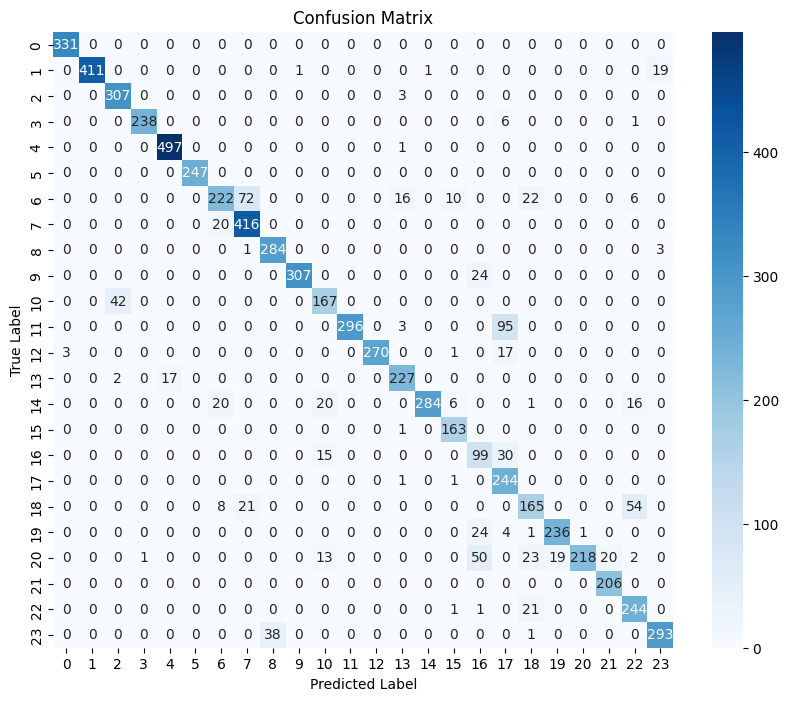

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Predict probabilities for the test set
y_pred_prob = final_model.predict(test_images)

# Convert probabilities to class labels (assumes one-hot encoding)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(test_labels_encoded, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the scores
print("Test Accuracy: {:.4f}".format(accuracy))
print("Test Precision (weighted): {:.4f}".format(precision))
print("Test Recall (weighted): {:.4f}".format(recall))
print("Test F1 Score (weighted): {:.4f}".format(f1))

# Display a detailed classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using Seaborn heatmap for visualization
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Save the final trained model to a file
final_model.save('sign_language_model_hyper_bay_connected.h5')